In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

### Catalogues of clusters and photon lists:

In [61]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [6]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

cosmology.setCosmology('planck18')
#p_nfw = profile_nfw.NFWProfile(M = 1E12, c = 10.0, z = 0.0, mdef = 'vir')

from colossus.halo import mass_so

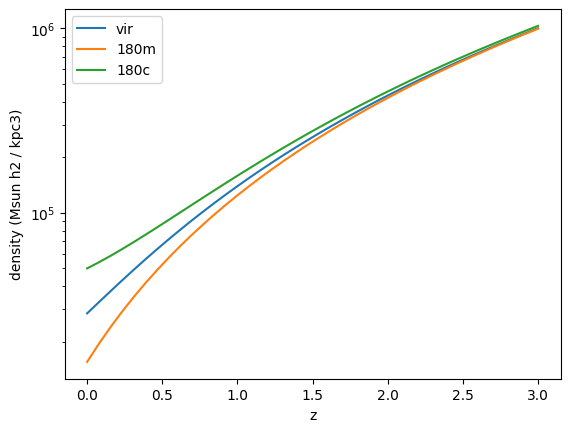

In [7]:
z = np.linspace(0.0, 3.0, 40)

plt.figure()
plt.yscale('log')
plt.xlabel('z')
plt.ylabel('density (Msun h2 / kpc3)')
plt.plot(z, mass_so.densityThreshold(z, 'vir'), label = 'vir');
plt.plot(z, mass_so.densityThreshold(z, '180m'), label = '180m');
plt.plot(z, mass_so.densityThreshold(z, '180c'), label = '180c');
plt.legend();

In [9]:
from colossus.halo import mass_defs
from colossus.halo import mass_adv

In [48]:
M200c = 1E14
c200 = 4
M500c, R500c, c500c = mass_defs.changeMassDefinition(M200c, c200, 0.0, '200c', '500c', profile='nfw')

print(M500c/M200c)

0.6919160075199818


In [59]:
M200c = 10E14
M500c, R500c, c500c = mass_adv.changeMassDefinitionCModel(M200c, 0.0, '200c', '500c', profile='nfw', c_model='diemer19')
print(M500c/M200c)

0.681927501778529


### Binning clusters:

In [62]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Catalogue of galaxies:

In [63]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


### Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19787,83,0.926032,0.822913,0.526959,0.02605,3.766600e+14,0.034717,0.033992,1.682650e+14,676.952,5.699780e+12,1.686950e+13,2.84568,0.951228,0.000004,2.866160e+14,1097.25,0


<Figure size 640x480 with 0 Axes>

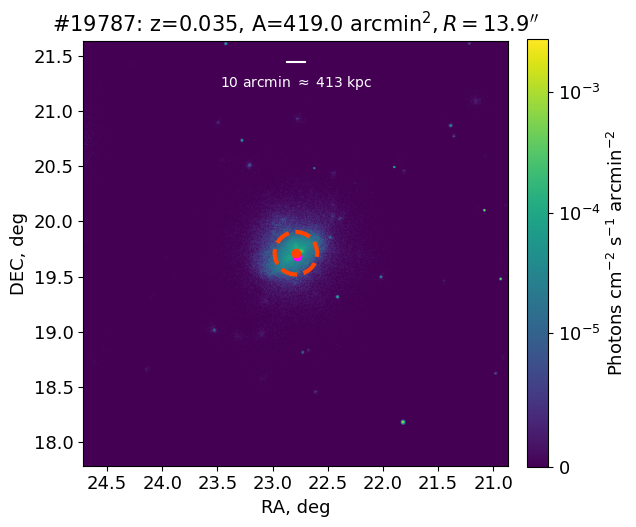

In [254]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 19787

display(clusters[clusters.index==cl_num])

pho_hist, plist = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True, 
                                        withagn=False, 
                                        ARF_weights=False)

plt.show()

#### This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 1000 pixels in length) to obtain the flux in corresponding units.

### Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

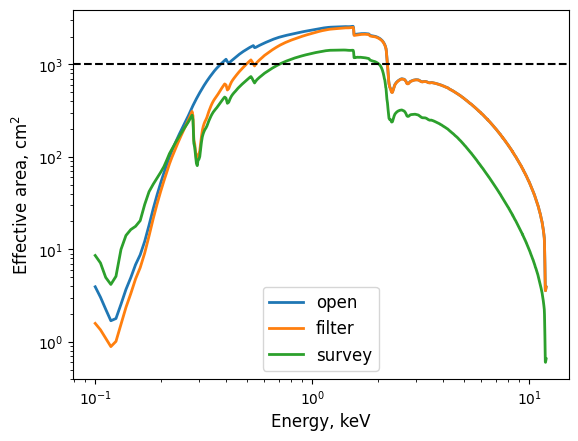

In [255]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

#### The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [256]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [257]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19787,83,0.926032,0.822913,0.526959,0.02605,3.766600e+14,0.034717,0.033992,1.682650e+14,676.952,5.699780e+12,1.686950e+13,2.84568,0.951228,0.000004,2.866160e+14,1097.25,0


<Figure size 640x480 with 0 Axes>

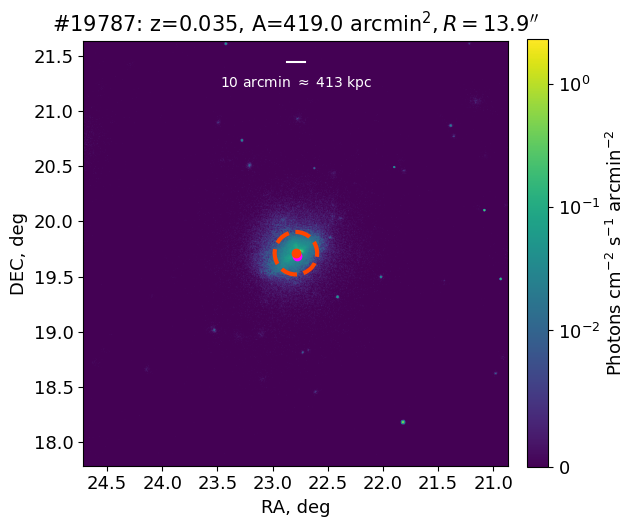

In [261]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

#cl_num = 19771

display(clusters[clusters.index==cl_num])

pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        withagn=False,
                                        ARF_weights=True)

plt.show()

### Stacking all the clusters:

In [240]:
%run -i 'utils/scripts.py'

length = 1000

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num, r = 1.0, draw=False, ARF_weights=True)
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

#### Drawing stacked image:

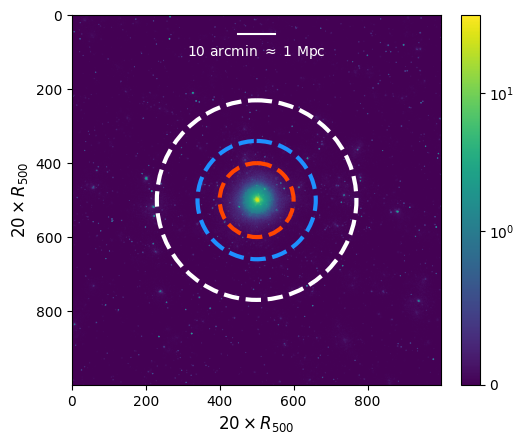

In [243]:
half_length = int(length/2)
r500r = int(half_length/5)

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=1
                                                                   , linscale=1), origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

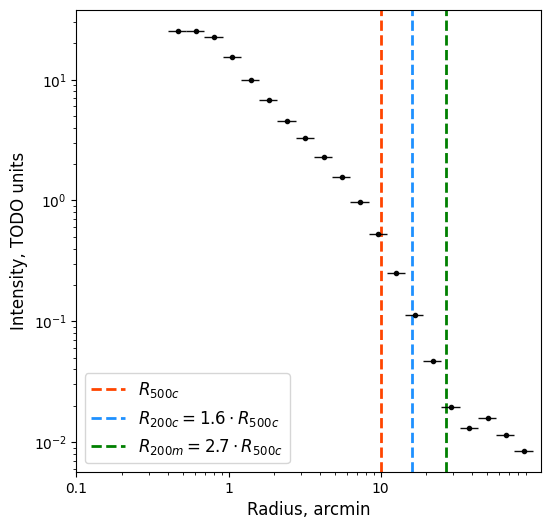

In [244]:
plt.figure(figsize=(6, 6))

brightness_profile(r500r = 50, 
                   total_hist=total_hist)

#print(pho_hist[pho_hist>100])

#display(plist)

plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


<Figure size 640x480 with 0 Axes>

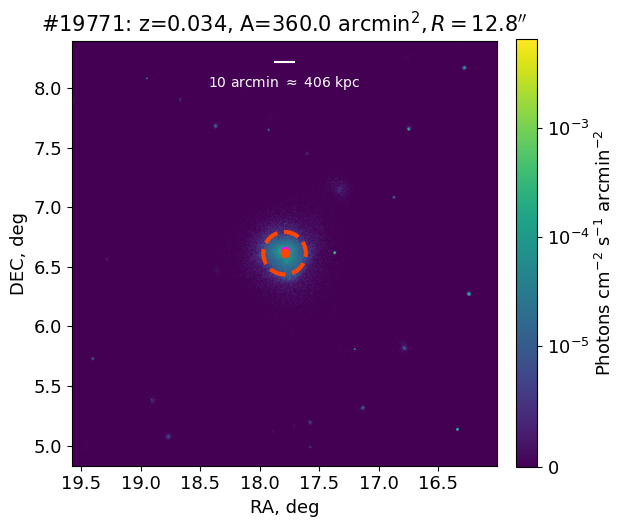

  0%|          | 0/20 [00:00<?, ?it/s]

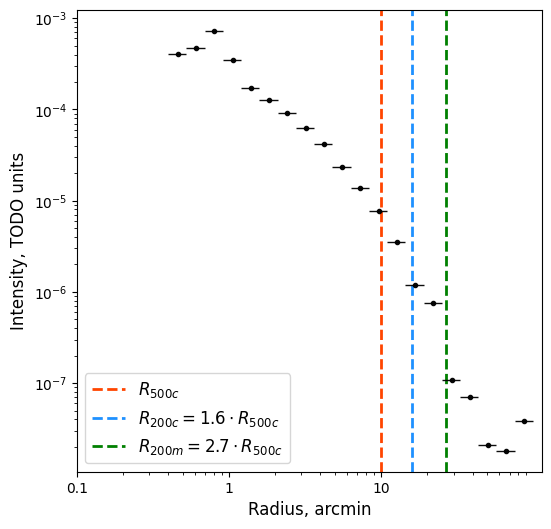

In [227]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

cl_num = 19771

display(clusters[clusters.index==cl_num])


pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        withagn=False,
                                        ARF_weights=False)

plt.show()

plt.figure(figsize=(6, 6))

brightness_profile(r500r = 50, total_hist = pho_hist)

#print(pho_hist[pho_hist>100])

#display(plist)

plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

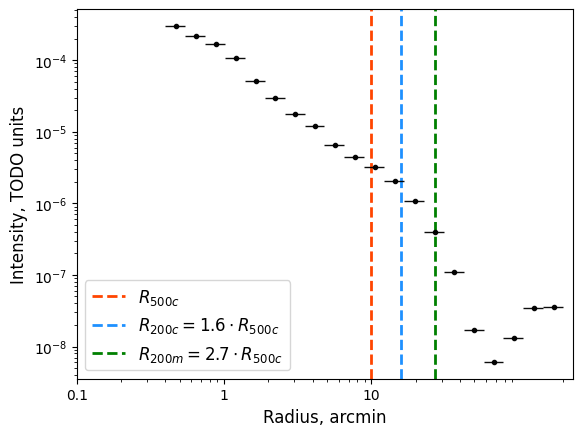

  0%|          | 0/20 [00:00<?, ?it/s]

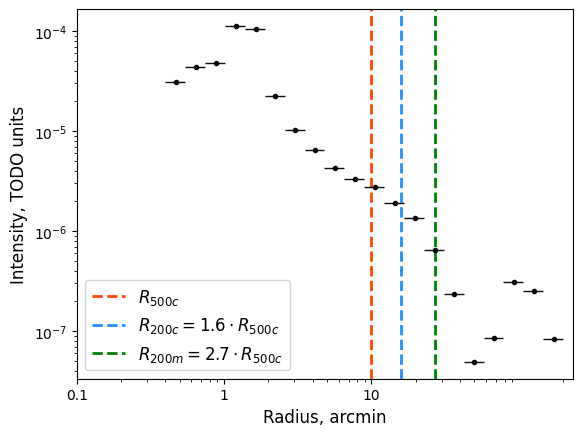

  0%|          | 0/20 [00:00<?, ?it/s]

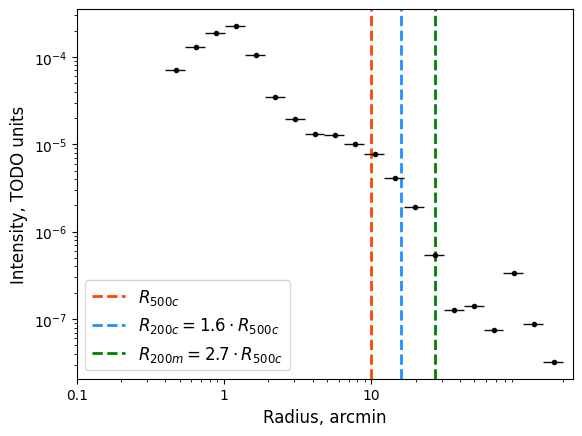

  0%|          | 0/20 [00:00<?, ?it/s]

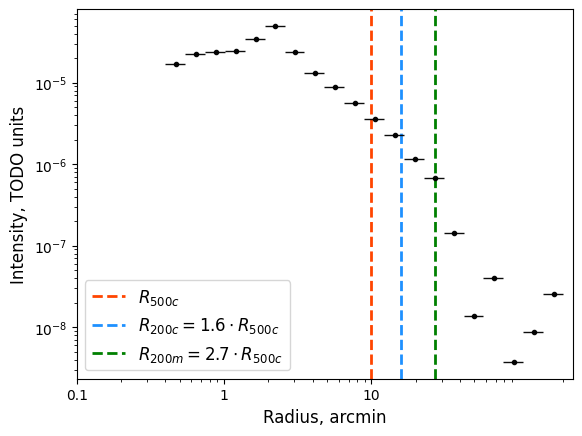

  0%|          | 0/20 [00:00<?, ?it/s]

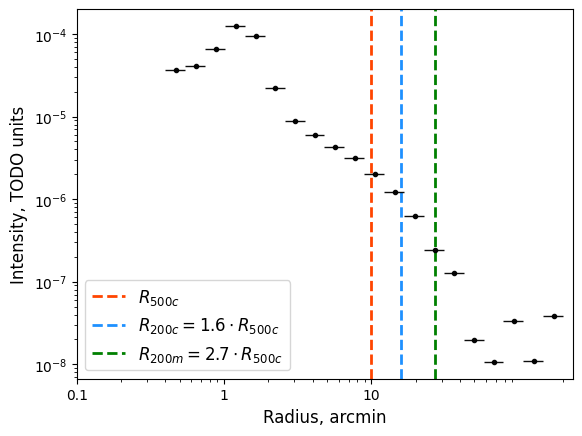

  0%|          | 0/20 [00:00<?, ?it/s]

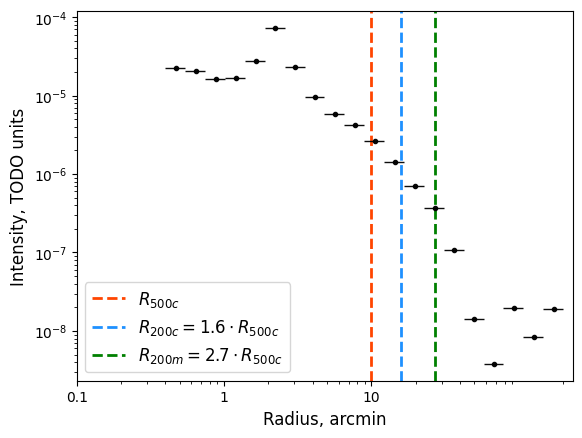

  0%|          | 0/20 [00:00<?, ?it/s]

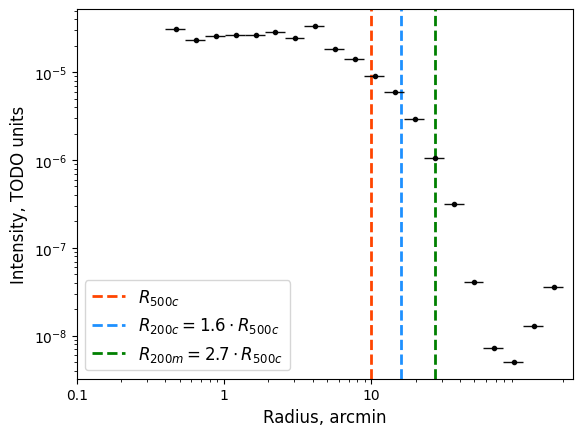

  0%|          | 0/20 [00:00<?, ?it/s]

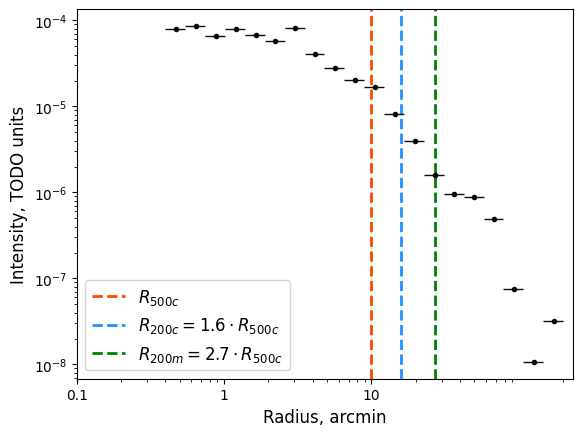

  0%|          | 0/20 [00:00<?, ?it/s]

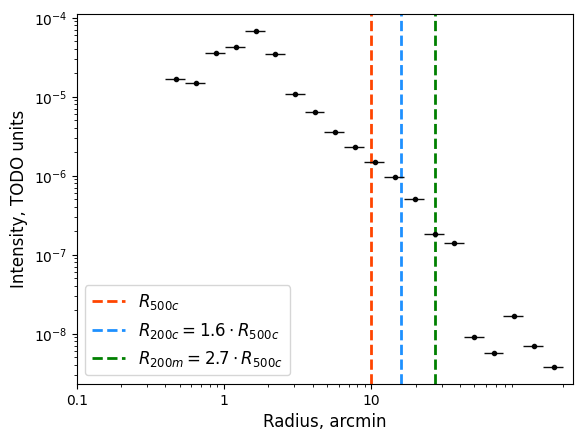

  0%|          | 0/20 [00:00<?, ?it/s]

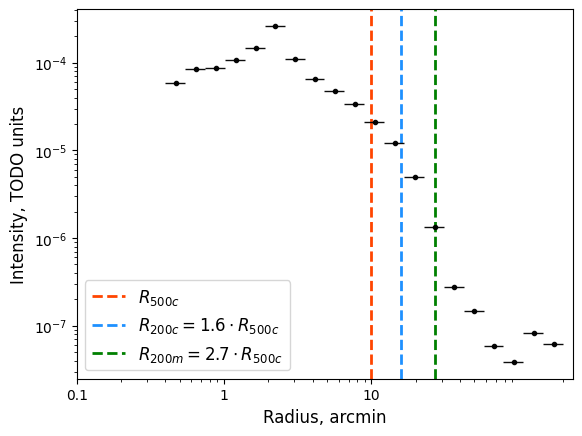

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [216]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('1.png', format='png', dpi=200, bbox_inches='tight')
plt.show()